<a href="https://colab.research.google.com/github/YousefAbyss/Python-Projects/blob/main/Molecular%20dynamics/MD_ND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann

In [153]:
mass_of_argon = 39.948 #  amu

* Lennard-Jones potential:
$$E_{attractive}(r) = -4𝜀(\frac{\sigma}{r})^{6}$$

$$E_{repulsive}(r) = 4𝜀(\frac{\sigma}{r})^{12}$$

$$E(r) = E_{repulsive}(r) + E_{attractive}(r)$$

$$f(r) = -\frac{∂E(r)}{∂r}$$

In [33]:
def lj_force(r_mag, epsilon, sigma):
    """
    Implementation of the Lennard-Jones potential 
    to calculate the force of the interaction.
    
    Parameters
    ----------
    r_mag: float
        Distance between two particles (Å)
    epsilon: float 
        Potential energy at the equilibrium bond 
        length (eV)
    sigma: float 
        Distance at which the potential energy is 
        zero (Å)
    
    Returns
    -------
    float
        Force of the van der Waals interaction (eV/Å)
    """
    attractive = 24 * epsilon * np.power(sigma, 6) / np.power(r_mag, 7)
    repulsive = 48 * epsilon * np.power(sigma, 12) / np.power(r_mag, 13)
    return repulsive - attractive

In [51]:
def init_velocity(temperature, n_particles, dimension):
    """
    Initialise the velocities for a series of 
    particles.
    
    Parameters
    ----------
    temperature: float
        Temperature of the system at 
        initialisation (K)
    n_particles: int
        Number of particles in the system
    dimension: int
        Number of dimensions for simulation
    
    Returns
    -------
    ndarray of floats
        Initial velocities for a series of 
        particles (eVs/Åamu)
    """
    if dimension == 1:
      rand = np.random.rand(n_particles) - 0.5
    else:
      rand = np.random.rand(n_particles, dimension) - 0.5
    v0 = rand * np.sqrt(Boltzmann * temperature / (mass_of_argon * 1.602e-19))
    return v0.T

* Velocity Verlet algorithm:
$${x}_i(t + \Delta t) = {x}_i(t) + {v}_i(t) \Delta t + \frac{1}{2}{a}_i(t)\Delta t^2$$
$${v}_i(t + \Delta t) = {v}_i(t) + \frac{1}{2}[{a}_i(t) + {a}_i(t + \Delta t)]\Delta t$$

In [87]:
def update_pos(r, v, a, dt):
    """
    Update the particle positions.
    
    Parameters
    ----------
    r: ndarray of floats
        The positions of the particles
    v: ndarray of floats
        The velocities of the particles
    a: ndarray of floats
        The accelerations of the particles
    dt: float
        The timestep length
    
    Returns
    -------
    ndarray of floats:
        New positions of the particles
    """
    return r + v * dt + 0.5 * a * dt * dt


def update_velo(v, a_pre, a_current, dt):
    """
    Update the particle velocities.
    
    Parameters
    ----------
    v: ndarray of floats
        The velocities of the particles (eVs/Åamu)
    a: ndarray of floats
        The accelerations of the particles at the previous 
        timestep (eV/Åamu)
    a1: ndarray of floats
        The accelerations of the particles at the current 
        timestep (eV/Åamu)
    dt: float
        The timestep length
    
    Returns
    -------
    ndarray of floats:
        New velocities of the particles (eVs/Åamu)
    """
    return v + 0.5 * (a_pre + a_current) * dt

In [82]:
def get_accelerations(positions, dimension):
    """
    Calculate the acceleration on each particle
    as a  result of each other particle. 
    
    Parameters
    ----------
    positions: ndarray of floats
        The positions, for all of the particles
    dimension: int
        Number of dimensions for simulation

    Returns
    -------
    ndarray of floats
        The acceleration on each
        particle (eV/Åamu)
    """
    size = positions.shape[1]
    accel = np.zeros((dimension, size, size))
    positions = positions.T
    for i in range(0, size - 1):
        for j in range(i + 1, size):
            r_temp = positions[j] - positions[i]
            rmag = np.sqrt(np.dot(r_temp, r_temp))
            force_scalar = lj_force(rmag, 0.0103, 3.4)
            force = force_scalar * r_temp / rmag
            accel[:, i, j] = force / mass_of_argon
            accel[:, j, i] = - force / mass_of_argon
    return np.sum(accel, axis=1)

In [88]:
def run_md(dt, steps, initial_temp, r, n_particles, dimension):
    """
    Run a MD simulation.
    
    Parameters
    ----------
    dt: float
        The timestep length (s)
    steps: int
        Number of iterations in the simulation
    initial_temp: float
        Temperature of the system at 
        initialisation (K)
    r: ndarray of floats
        The initial positions of the particles (Å)
    n_particles: int
        Number of particles in the system
    dimensions: int
        Number of dimensions for simulation

    Returns
    -------
    ndarray of floats
        The positions for all of the particles 
        throughout the simulation (Å)
    """
    positions = np.zeros((steps, dimension, n_particles))
    positions[0] = r
    v = init_velocity(initial_temp, n_particles, dimension)
    a = get_accelerations(r, dimension)
    for i in range(1, steps):
        r = update_pos(r, v, a, dt)
        a1 = get_accelerations(r, dimension)
        v = update_velo(v, a, a1, dt)
        a = a1.copy()
        positions[i, :] = r.copy()
    return positions

In [140]:
r0 = np.array([[1, 4, 8],[1, 5, 8]])
sim_pos = run_md(dt=0.1, steps=20000, initial_temp=300, r=r0, n_particles=3, dimension=2)

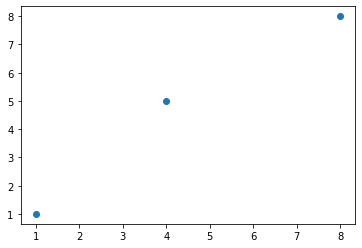

In [141]:
plt.plot(sim_pos[0, :][0], sim_pos[0, :][1], 'o')
plt.show()

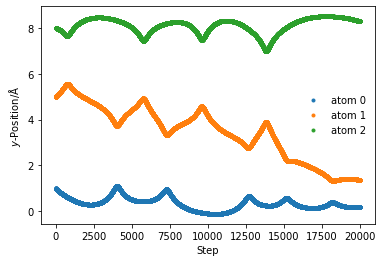

In [147]:
for i in range(3):
  plt.plot(sim_pos[:, 1, i], '.', label='atom {}'.format(i))
plt.xlabel(r'Step')
plt.ylabel(r'$y$-Position/Å')
plt.legend(frameon=False)
plt.show()

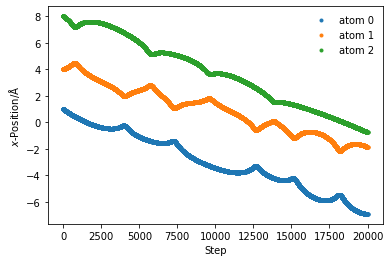

In [148]:
for i in range(3):
  plt.plot(sim_pos[:, 0, i], '.', label='atom {}'.format(i))
plt.xlabel(r'Step')
plt.ylabel(r'$x$-Position/Å')
plt.legend(frameon=False)
plt.show()

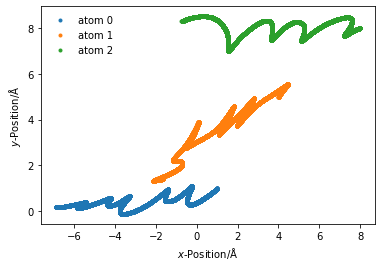

In [150]:
for i in range(3):
  plt.plot(sim_pos[:, 0, i], sim_pos[:, 1, i], '.', label='atom {}'.format(i))
plt.xlabel(r'$x$-Position/Å')
plt.ylabel(r'$y$-Position/Å')
plt.legend(frameon=False)
plt.show()